In [1]:
import qutip as qt
import QNN as qnn
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

2024-10-09 12:21:33.031212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 12:21:33.031231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 12:21:33.032038: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1 Physical GPUs, 1 Logical GPUs


In [12]:
df = pd.read_csv('Parameters/Kerr/Function_5/parameters_fold_3.csv')

for i in range(2): 
    df[f'Layer{i}_bx'] = df[[f'Layer{i}_bx', f'Layer{i}_bp']].apply(tuple, axis=1)
    
    df = df.drop(columns=[f'Layer{i}_bp'])
    df = df.rename(columns={f'Layer{i}_bx': f'Layer{i}_bx_bp'})

In [13]:
def state(x, dim, epoch=0, layer=0, sublayer=0, params=df):
    psi = qnn.get_vacuum_state_tf(dim)
    psi = tf.matmul(qnn.squeezing_operator(dim, r=100), psi)
    psi = tf.matmul(qnn.displacement_operator(dim, x/2, 0.0), psi)
    
    if epoch == 0 or layer == 0 or sublayer == 0:
        return qt.Qobj(tf.squeeze(psi, axis=-1).numpy())
    
    N = layer * sublayer
    P = tf.constant(params[params.columns[1:N+1]].iloc[epoch+1].values, dtype=tf.float32)
    
    ops = [qnn.rotation_operator, qnn.squeezing_operator, qnn.rotation_operator, qnn.displacement_operator, qnn.kerr_operator]
    num_ops = len(ops)
    
    def apply_ops(psi, i):
        op_index = i % num_ops
        op = ops[op_index]
        param = P[i]
        if op == qnn.displacement_operator:
            return tf.matmul(op(dim, param, 0.0), psi)
        else:
            return tf.matmul(op(dim, param), psi)
    
    indices = tf.range(N)
    psi = tf.foldl(apply_ops, indices, initializer=psi)
    
    return qt.Qobj(tf.squeeze(psi, axis=-1).numpy())

In [14]:
from matplotlib import cm

def wigner_plot(x, dim = 20, epoch = 0, layer = 0, sublayer = 0):
    psi = state(x, dim, epoch, layer, sublayer)
    
    xvec = np.linspace(-7, 7, 200)
    pvec = xvec
    W = qt.wigner(psi, xvec, pvec)

    wmap = qt.wigner_cmap(W)
    nrm = mpl.colors.Normalize(-W.max(), W.mplt())
    wplot = plt.figure(figsize=(8,8))
    wplot = plt.contourf(xvec, xvec, W, 100, cmap=wmap)  
    plt.gca().set_aspect('equal')

    plt.title("Wigner Colormap")
    cb2 = plt.colorbar(wplot)

    #plt.tight_layout()
    
    plt.show()

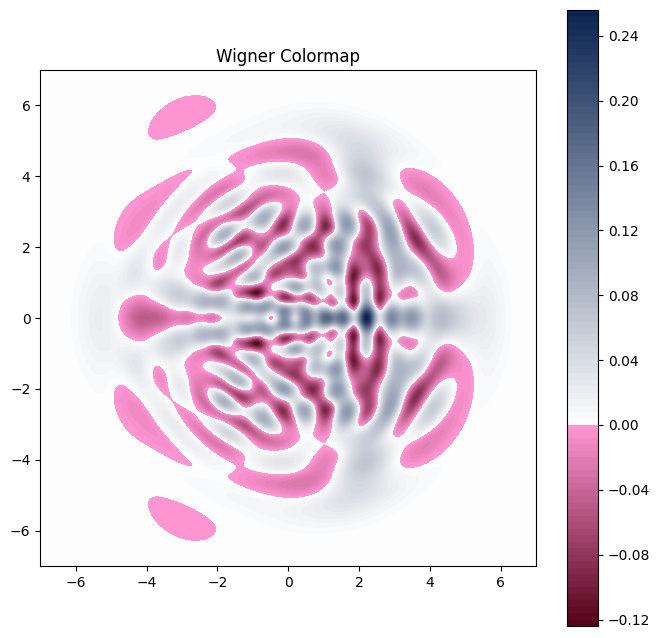

In [15]:
wigner_plot(np.pi)

In [57]:
def sample_points(x, dim=10):    
    # Define the phase space
    x = tf.cast(x, dtype=tf.float32)
    xvec = np.linspace(-7, 7, 200)
    pvec = xvec
    
    max_x = []
    max_p = []
    
    for xi in x:
        # Calculate state for each x value
        psi = state(xi, dim)
        
        # Calculate Wigner function
        W = qt.wigner(psi, xvec, pvec)
        
        # Find indices of maximum W value
        max_index = np.unravel_index(np.argmax(W), W.shape)
        
        # Get corresponding xvec and pvec values
        max_x.append(xvec[max_index[1]])
        max_p.append(pvec[max_index[0]])
    
    # Combine results
    result = np.column_stack((max_x, max_p))
    
    return result

In [62]:
x = np.linspace(-np.pi,np.pi,200).reshape(-1,1)

def f5(x, eps=0.0):
    """The function f(x)=x^3+noise"""
    return x**3 + eps * np.random.normal(size=x.shape)

y = f5(x, eps=0.1)
y = (y - np.min(y))/(np.max(y)-np.min(y))

In [63]:
from sklearn.model_selection import KFold

# Function for training classical models
def train_classical_model(input_data, target_data, function_index, k_folds=5, learning_rate=0.01, std=0.05, non_linearity='kerrlike', num_layers=2, epochs=200):
    
    samples = sample_points(input_data)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    print(f'Training classical model for Function {function_index} with {num_layers} layers for {epochs} epochs...')
    
    fold_histories = []
    models = []

    for fold, (train_index, val_index) in enumerate(kf.split(samples), 1):
        print(f'Training on fold {fold}...')
        
        x_train_fold, x_val_fold = samples[train_index], samples[val_index]
        y_train_fold, y_val_fold = target_data[train_index], target_data[val_index]

        # Create a new model for each fold
        layers = [qnn.CPLayer(stddev=std, activation=non_linearity) for _ in range(num_layers)] + [qnn.ExtractXLayer()]
        model = tf.keras.Sequential(layers)

        # Compile the model
        opt = tf.keras.optimizers.Adam(learning_rate, clipnorm=1.0)
        model.compile(optimizer=opt, loss='mse', metrics=[qnn.R2ScoreWrapper()])
        
        # Train the model
        history = model.fit(x_train_fold, y_train_fold, validation_data=(x_val_fold, y_val_fold), 
                            epochs=epochs, verbose=0, callbacks=[qnn.TrainingProgress()])

        fold_histories.append(history.history)
        models.append(model)
        
        print(f'Fold {fold} complete.')

    # Calculate average cross-validated histories
    avg_history = {key: np.mean([h[key] for h in fold_histories], axis=0) for key in fold_histories[0].keys()}
    
    # Find the best model based on final validation loss
    best_model_index = np.argmin([h['val_loss'][-1] for h in fold_histories])
    best_model = models[best_model_index]

    print('Cross-validation complete.')
    print(f'Best model from fold {best_model_index + 1}')
    best_model.summary()

    return avg_history, best_model

In [66]:
H, M = train_classical_model(x, y, 5, num_layers=6, epochs=500)

Fold 5 complete.
Cross-validation complete.
Best model from fold 5
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cp_layer_48 (CPLayer)       (None, 2)                 6         
                                                                 
 cp_layer_49 (CPLayer)       (None, 2)                 6         
                                                                 
 cp_layer_50 (CPLayer)       (None, 2)                 6         
                                                                 
 cp_layer_51 (CPLayer)       (None, 2)                 6         
                                                                 
 cp_layer_52 (CPLayer)       (None, 2)                 6         
                                                                 
 cp_layer_53 (CPLayer)       (None, 2)                 6         
                                                     

In [74]:
X = np.hstack((x, np.zeros(x.shape)))
y_preds = M.predict(X, verbose = 0)

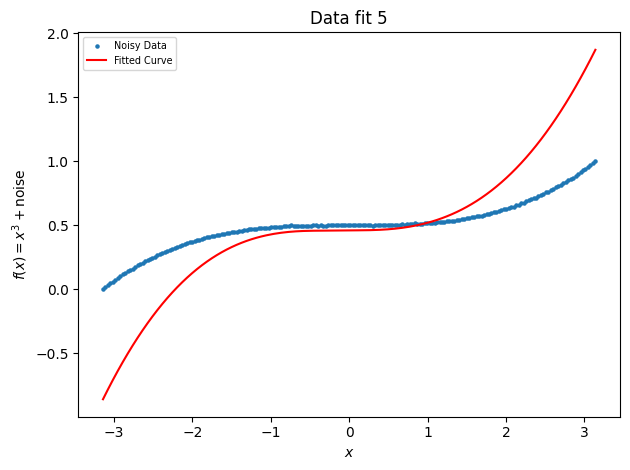

In [75]:
y_preds = M.predict(X, verbose = 0)
y_labels = [
    r'$f(x) = |x| + \text{noise}$',
    r'$f(x) = \sin(x) + \text{noise}$',
    r'$f(x) = \exp(x) + \text{noise}$',
    r'$f(x) = \log(x+2\pi) + \text{noise}$',
    r'$f(x) = x^3 + \text{noise}$',
    r'$f(x) = \exp(x^2/2) + \text{noise}$'
]

plt.scatter(x, y, s=5, label="Noisy Data")
plt.plot(x, y_preds, label='Fitted Curve', color='r')
plt.title(f'Data fit {4+1}')
plt.xlabel(r'$x$')
plt.ylabel(y_labels[4])
plt.legend(fontsize='x-small')

plt.tight_layout()
#cfit.savefig('fits_classical.png')
plt.show()